##### Imports

In [1]:
# %pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, Tuple
from scipy.stats import norm, invgamma, multivariate_normal
import pickle

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

warnings.filterwarnings('ignore')

# Loading Saved Model

LOADED MODEL INFORMATION

2. KAMA PARAMETERS:
----------------------------------------
KAMA n: 18
KAMA n_fast: 10
    KAMA k_fast: 0.181818
KAMA n_slow: 44
    KAMA k_slow: 0.044444
gamma: 1.3500000000000003

3. MSR PRIORS:
----------------------------------------
mean_prior_mean: 0.0
mean_prior_var: 0.1
beta_prior_mean: 0.0
beta_prior_var: 1.0
sigma_prior_shape: 2.0
sigma_prior_scale: 0.1
transition_prior_alpha: 8.0

4. MODEL CONFIGURATION:
----------------------------------------
use_three_state_msr: False
Number of combined regimes: 4
MSR n_regimes: 2

5. DATA INFORMATION:
----------------------------------------
Price data length: 6042
Return data length: 6041
Regime labels length: 6023
Regime changes: 57

6. MSR PARAMETERS (Post-Fit):
----------------------------------------
MSR Means (μ):
  Regime 0: 0.000477
  Regime 1: -0.002591

MSR Betas (β):
  Regime 0: -0.0127
  Regime 1: -0.0257

MSR Standard Deviations (σ):
  Regime 0: 0.011156
  Regime 1: 0.038046

MSR Transition Probabi

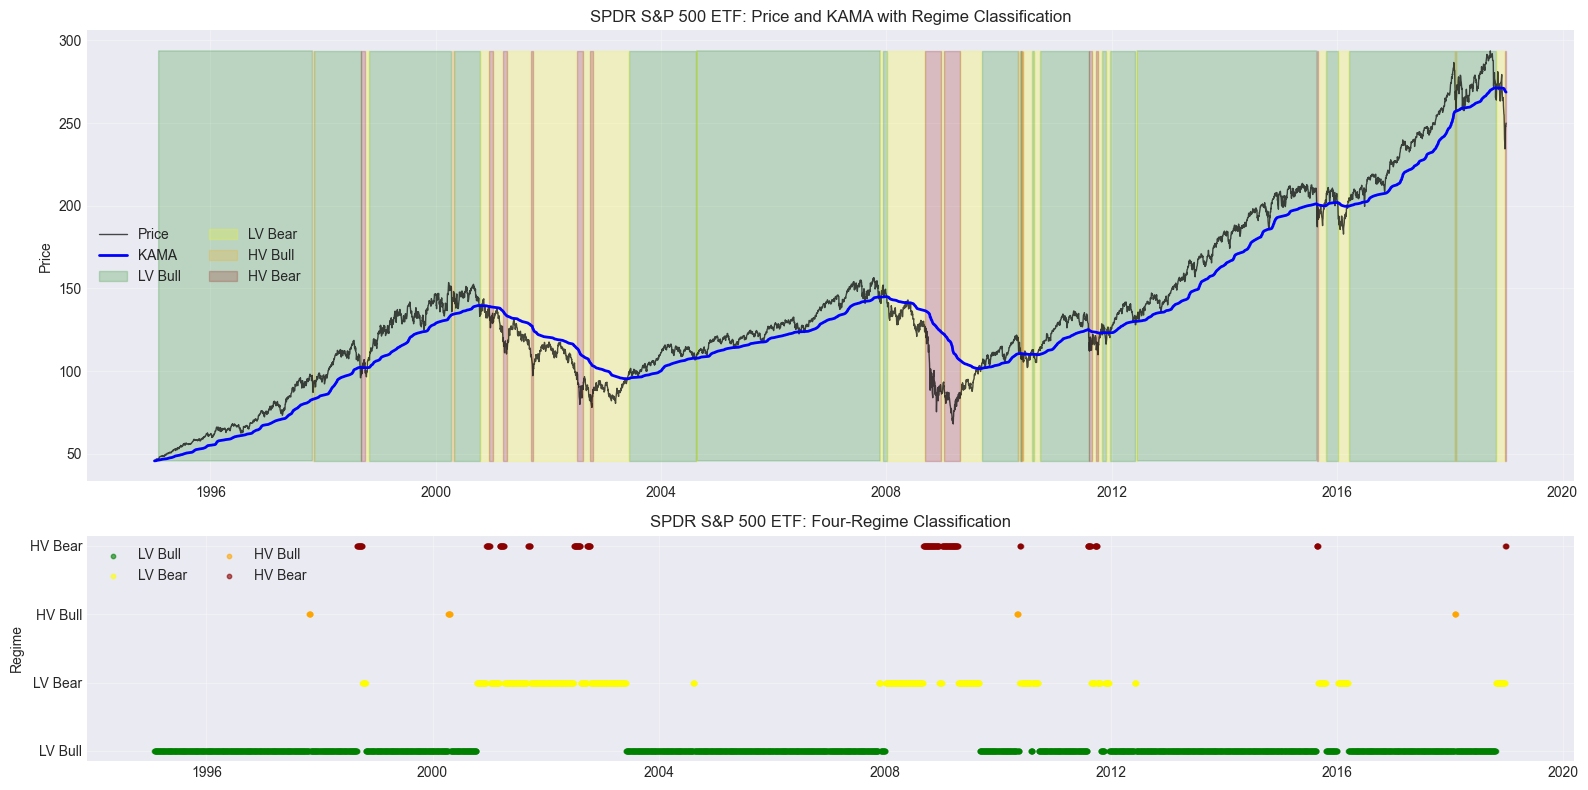

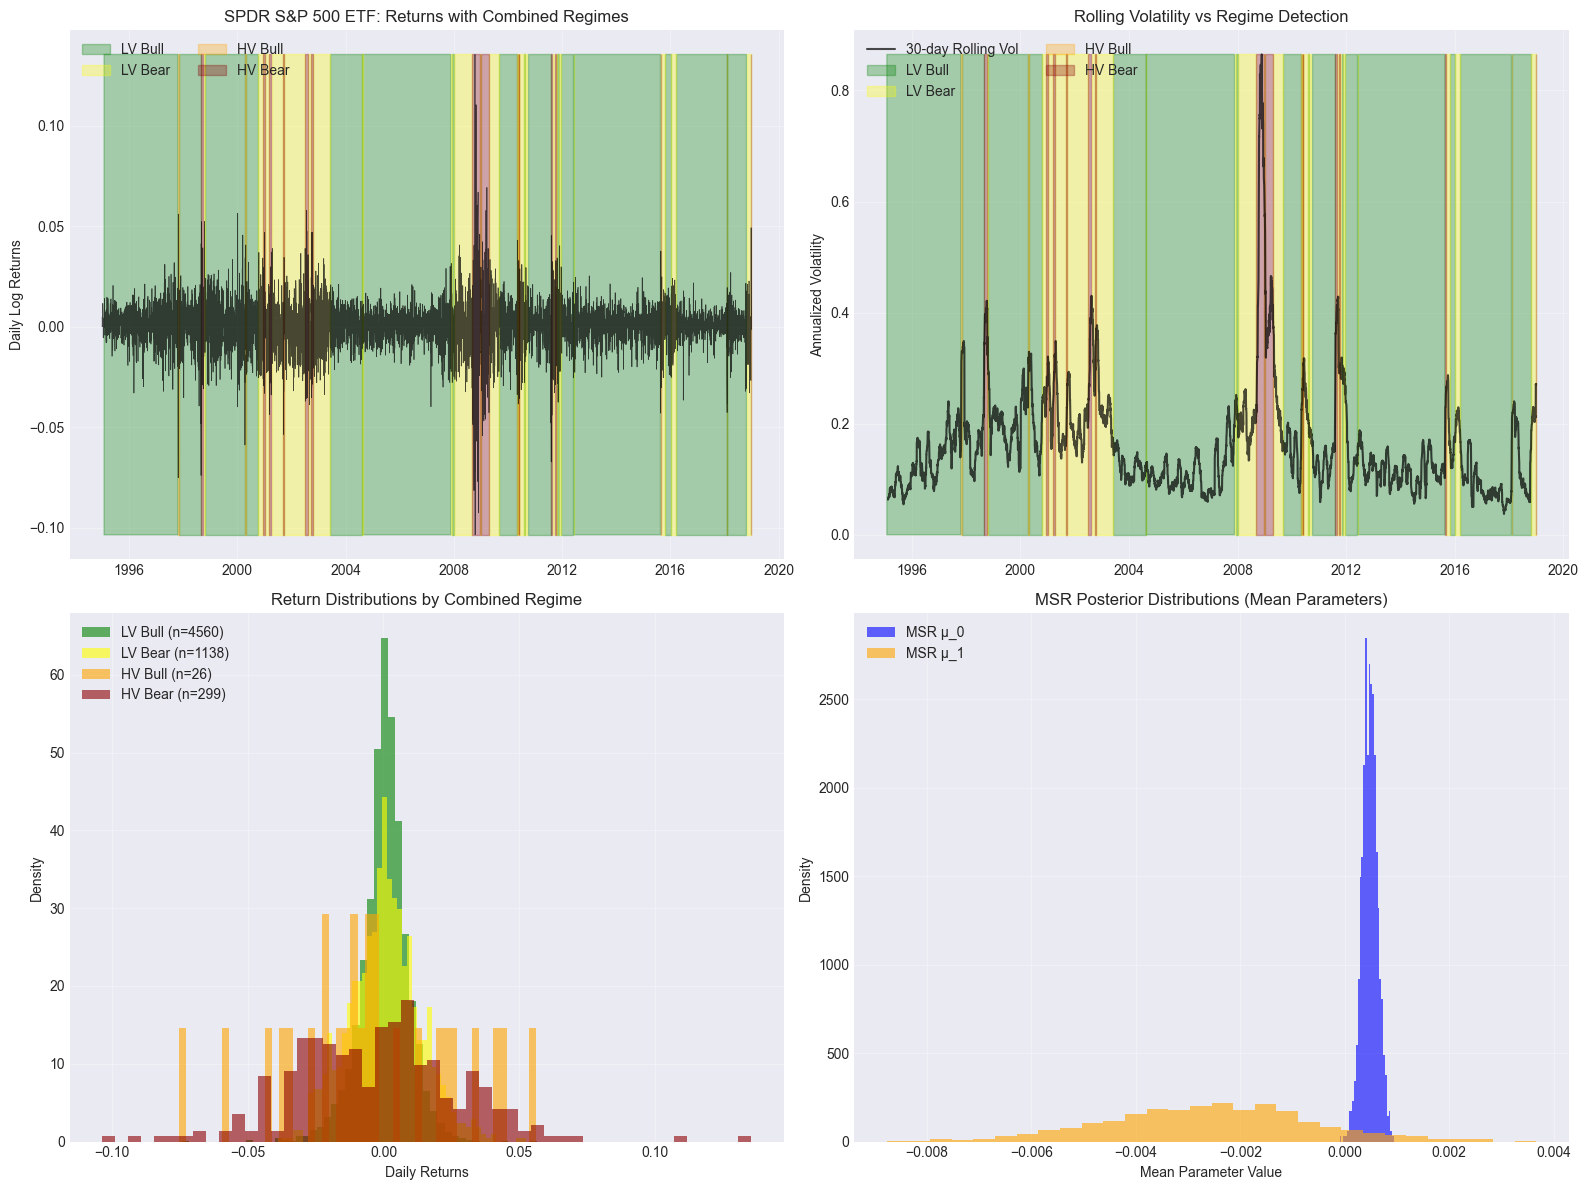


KAMA+MSR MODEL DIAGNOSTICS - SPDR S&P 500 ETF

Combined Model Fit Statistics:
Log-Likelihood: 18556.04
Average Log-Likelihood: 3.07

KAMA Tracking Error (vs returns): 0.011787
KAMA Efficiency Ratio (mean): 0.2381

Regime Stability:
  Total regime changes: 57
  Average regime duration: 104.2 periods
  Change frequency: 0.94%


In [3]:
def load_and_analyze_KAMA_MSR_model(asset_name: str, n_regimes: int, sub_folder: str, edte_sub_folder: str) -> None:
    pkl_file_path = f'saved_models/KAMA_MSR/{sub_folder}/{edte_sub_folder}/{asset_name}_KAMA-MSR_{n_regimes*2}-regimes.pkl'
    with open(pkl_file_path, 'rb') as f:
        loaded_model = pickle.load(f)

    print("="*80)
    print("LOADED MODEL INFORMATION")
    print("="*80)

    # ============================================================================
    # 2. ACCESS KAMA PARAMETERS
    # ============================================================================
    print("\n2. KAMA PARAMETERS:")
    print("-" * 40)
    print(f"KAMA n: {loaded_model.kama.n}")
    print(f"KAMA n_fast: {loaded_model.kama.n_fast}")
    print(f"    KAMA k_fast: {loaded_model.kama.k_fast:.6f}")
    print(f"KAMA n_slow: {loaded_model.kama.n_slow}")
    print(f"    KAMA k_slow: {loaded_model.kama.k_slow:.6f}")
    print(f"gamma: {loaded_model.gamma}")

    # ============================================================================
    # 3. ACCESS PRIORS (AFTER OPTIMIZATION)
    # ============================================================================
    print("\n3. MSR PRIORS:")
    print("-" * 40)

    # The priors used during model initialization
    priors = loaded_model.msr.priors
    for param, value in priors.items():
        print(f"{param}: {value}")

    # ============================================================================
    # 4. ACCESS MODEL CONFIGURATION
    # ============================================================================
    print("\n4. MODEL CONFIGURATION:")
    print("-" * 40)
    print(f"use_three_state_msr: {loaded_model.use_three_state_msr}")
    print(f"Number of combined regimes: {loaded_model.n_combined_regimes}")
    print(f"MSR n_regimes: {loaded_model.msr.n_regimes}")

    # ============================================================================
    # 5. CHECK DATA DIMENSIONS
    # ============================================================================
    print("\n5. DATA INFORMATION:")
    print("-" * 40)
    if loaded_model.prices is not None:
        print(f"Price data length: {len(loaded_model.prices)}")
        print(f"Return data length: {len(loaded_model.returns)}")
        print(f"Regime labels length: {len(loaded_model.regime_labels.dropna())}")
        print(f"Regime changes: {(loaded_model.regime_labels.diff() != 0).sum()}")

    # ============================================================================
    # 6. ACCESS MSR PARAMETERS (AFTER FITTING)
    # ============================================================================
    print("\n6. MSR PARAMETERS (Post-Fit):")
    print("-" * 40)
    print("MSR Means (μ):")
    for i, mean in enumerate(loaded_model.msr.means):
        print(f"  Regime {i}: {mean:.6f}")

    print("\nMSR Betas (β):")
    for i, beta in enumerate(loaded_model.msr.betas):
        print(f"  Regime {i}: {beta:.4f}")

    print("\nMSR Standard Deviations (σ):")
    for i, std in enumerate(loaded_model.msr.stds):
        print(f"  Regime {i}: {std:.6f}")

    print("\nMSR Transition Probabilities:")
    print("          To Regime:")
    print("From      0       1" + ("       2" if loaded_model.msr.n_regimes == 3 else ""))
    print("Regime")
    for i in range(loaded_model.msr.n_regimes):
        row = f"  {i}    "
        for j in range(loaded_model.msr.n_regimes):
            row += f"  {loaded_model.msr.transition_probs[i,j]:.3f}"
        print(row)


    # ============================================================================
    # 7. RUN ANALYSIS ON LOADED MODEL
    # ============================================================================
    print("\n7. RUNNING FULL ANALYSIS ON LOADED MODEL...")
    loaded_model.analyze_results(data_name=asset_name)
    regime_duration_stats = loaded_model.analyze_regime_durations()
    print("\nRegime Duration Statistics:")
    print(regime_duration_stats)
    loaded_model.regime_characteristics(data_name=asset_name)
    transition_results = loaded_model.regime_transition_analysis(in_depth=False)
    loaded_model.plot_regimes(data_name=asset_name)
    # loaded_model.plot_regime_duration_distribution()
    loaded_model.plot_comprehensive_analysis(data_name=asset_name)
    loaded_model.diagnostics(data_name=asset_name, trace_plots=False)
    
    return loaded_model, transition_results

asset_name = 'SPDR S&P 500 ETF'
n_regimes = 2
sub_folder = 'us_equity'
edte_sub_folder = datetime(2019, 1, 1).strftime('%Y%m%d')
loaded_model, transition_results = load_and_analyze_KAMA_MSR_model(asset_name, n_regimes, sub_folder, edte_sub_folder)

In [4]:
level1_transition_matrix = transition_results[1]['transition_probabilities']\
    .rename(columns={0: 'Low Vol Bull', 1: 'Low Vol Bear', 2: 'High Vol Bull', 3: 'High Vol Bear'},
            index={0: 'Low Vol Bull', 1: 'Low Vol Bear', 2: 'High Vol Bull', 3: 'High Vol Bear'})\
            .rename_axis('From').rename_axis('To', axis=1).round(4) * 100

level1_transition_matrix

To,Low Vol Bull,Low Vol Bear,High Vol Bull,High Vol Bear
From,,,,
Low Vol Bull,99.63,0.22,0.09,0.07
Low Vol Bear,1.05,97.98,0.00,0.97
High Vol Bull,15.38,0.00,84.62,0.00
High Vol Bear,0.00,4.36,0.00,95.64


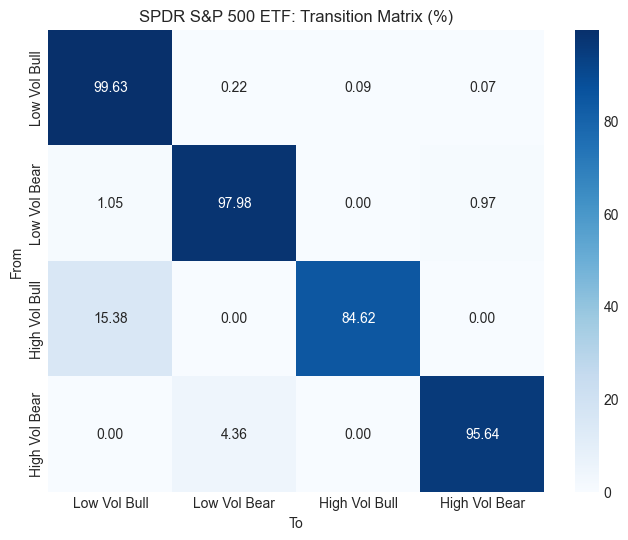

In [5]:
# Heatmap of level 1 transition matrix
plt.figure(figsize=(8, 6))
sns.heatmap(level1_transition_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title(f"{asset_name}: Transition Matrix (%)")
plt.show()

In [6]:
level2_transition_matrix = transition_results[1]['level_two_transition_probabilities']\
    .rename_axis('From').rename_axis('To', axis=1).round(4) * 100

level2_transition_matrix

To,Low Vol Bull,Low Vol Bear,High Vol Bull,High Vol Bear
From,,,,
Low Vol Bull → Low Vol Bear (n=10),60.00,0.00,0.0,40.00
Low Vol Bull → High Vol Bull (n=4),100.00,0.00,0.0,0.00
Low Vol Bull → High Vol Bear (n=3),0.00,100.00,0.0,0.00
Low Vol Bear → Low Vol Bull (n=12),0.00,58.33,25.0,16.67
Low Vol Bear → High Vol Bear (n=10),0.00,100.00,0.0,0.00
High Vol Bull → Low Vol Bull (n=4),0.00,75.00,0.0,25.00
High Vol Bear → Low Vol Bear (n=13),46.15,0.00,0.0,53.85


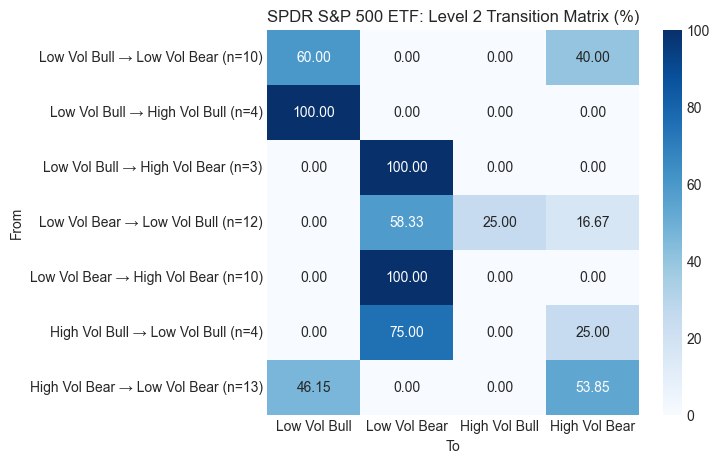

In [7]:
# Heatmap of Level 2 transition matrix
plt.figure(figsize=(6, 5))
sns.heatmap(level2_transition_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title(f"{asset_name}: Level 2 Transition Matrix (%)")
plt.show()

# More Plots

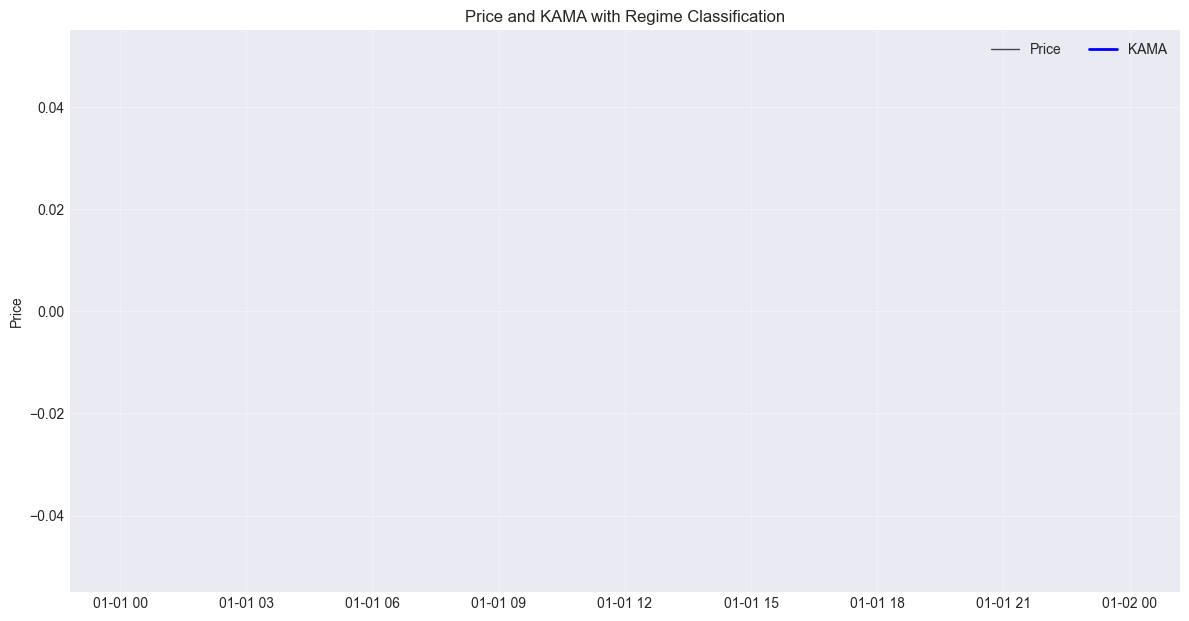

In [8]:
regime_labels_clean = loaded_model.regime_labels.dropna()

sdte = datetime(2020, 1, 1)
edte = datetime(2020, 12, 31)
regime_labels_clean = regime_labels_clean.loc[sdte:edte]
prices = loaded_model.prices.loc[regime_labels_clean.index]
kama_values = loaded_model.kama_values.loc[regime_labels_clean.index]

fig = plt.figure(figsize=(12, 24))

if loaded_model.use_three_state_msr:
    colors = {0: 'green', 1: 'blue', 2: 'yellow',
             3: 'orange', 4: 'purple', 5: 'red'}
    regime_names = {0: 'LV Bull', 1: 'LV Bear', 2: 'MV Bull',
                   3: 'MV Bear', 4: 'HV Bull', 5: 'HV Bear'}
else:
    colors = {0: 'green', 1: 'yellow', 2: 'orange', 3: 'darkred'}
    regime_names = {0: 'LV Bull', 1: 'LV Bear', 2: 'HV Bull', 3: 'HV Bear'}

# Plot 1: Price and KAMA
ax1 = fig.add_subplot(411)
ax1.plot(prices.index, prices, label='Price', 
        color='black', alpha=0.7, linewidth=1)
ax1.plot(kama_values.index, kama_values, 
        label='KAMA', color='blue', linewidth=2)

for regime in range(loaded_model.n_combined_regimes):
    mask = (regime_labels_clean == regime)
    if mask.any():
        mask_aligned = pd.Series(False, index=loaded_model.prices.index)
        mask_aligned.loc[regime_labels_clean.index[mask]] = True
        
        ax1.fill_between(loaded_model.prices.index, loaded_model.prices.min(), loaded_model.prices.max(),
                       where=mask_aligned.values, alpha=0.2, color=colors[regime],
                       label=regime_names[regime])

ax1.set_title('Price and KAMA with Regime Classification')
ax1.set_ylabel('Price')
ax1.legend(loc='best', ncol=2)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
